In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns



# Load the dataset
path = "/content/Real_Estate_Sales_2001-2022_GL.csv"
df = pd.read_csv(path,low_memory=False)

# Display basic information about the dataset
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097629 entries, 0 to 1097628
Data columns (total 14 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Serial Number     1097629 non-null  int64  
 1   List Year         1097629 non-null  int64  
 2   Date Recorded     1097627 non-null  object 
 3   Town              1097629 non-null  object 
 4   Address           1097578 non-null  object 
 5   Assessed Value    1097629 non-null  float64
 6   Sale Amount       1097629 non-null  float64
 7   Sales Ratio       1097629 non-null  float64
 8   Property Type     715183 non-null   object 
 9   Residential Type  699240 non-null   object 
 10  Non Use Code      313451 non-null   object 
 11  Assessor Remarks  171228 non-null   object 
 12  OPM remarks       13031 non-null    object 
 13  Location          298111 non-null   object 
dtypes: float64(3), int64(2), object(9)
memory usage: 117.2+ MB


(None,
    Serial Number  List Year Date Recorded     Town          Address  \
 0        2020177       2020    04/14/2021  Ansonia    323 BEAVER ST   
 1        2020225       2020    05/26/2021  Ansonia   152 JACKSON ST   
 2        2020348       2020    09/13/2021  Ansonia  230 WAKELEE AVE   
 3        2020090       2020    12/14/2020  Ansonia      57 PLATT ST   
 4         200500       2020    09/07/2021     Avon     245 NEW ROAD   
 
    Assessed Value  Sale Amount  Sales Ratio Property Type Residential Type  \
 0        133000.0     248400.0       0.5354   Residential    Single Family   
 1        110500.0     239900.0       0.4606   Residential     Three Family   
 2        150500.0     325000.0       0.4630    Commercial              NaN   
 3        127400.0     202500.0       0.6291   Residential       Two Family   
 4        217640.0     400000.0       0.5441   Residential    Single Family   
 
   Non Use Code Assessor Remarks OPM remarks                    Location  
 0      

### Initial Observations:
- The dataset has 1,097,629 records and 14 columns.
- Some columns, like `Property Type`, `Residential Type`, `Non Use Code`, `Assessor Remarks`, `OPM Remarks`, and `Location`, have many missing values.
- The columns `Date Recorded` and `Location` are in string format and may need conversion.
- A `DtypeWarning` indicates mixed data types in columns 8-12.

In [ ]:
# Check for missing values
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_values / len(df)) * 100

# Summary statistics for numerical columns
summary_stats = df.describe()

missing_values, missing_percentage, summary_stats


(OPM remarks         1084598
 Assessor Remarks     926401
 Location             799518
 Non Use Code         784178
 Residential Type     398389
 Property Type        382446
 Address                  51
 Date Recorded             2
 Serial Number             0
 List Year                 0
 Town                      0
 Assessed Value            0
 Sale Amount               0
 Sales Ratio               0
 dtype: int64,
 OPM remarks         98.812805
 Assessor Remarks    84.400194
 Location            72.840459
 Non Use Code        71.442901
 Residential Type    36.295415
 Property Type       34.842921
 Address              0.004646
 Date Recorded        0.000182
 Serial Number        0.000000
 List Year            0.000000
 Town                 0.000000
 Assessed Value       0.000000
 Sale Amount          0.000000
 Sales Ratio          0.000000
 dtype: float64,
        Serial Number     List Year  Assessed Value   Sale Amount   Sales Ratio
 count   1.097629e+06  1.097629e+06    1.097629e

### Key Findings:

#### Missing Data:
- Columns like `OPM remarks` (98.8%), `Assessor Remarks` (84.4%), `Location` (72.8%), and `Non Use Code` (71.4%) have significant missing values.
- `Property Type` (34.8%) and `Residential Type` (36.3%) also have missing data.
- `Date Recorded` (0.0002%) and `Address` (0.0046%) have minimal missing values.

#### Numerical Data Insights:
- `Assessed Value`, `Sale Amount`, and `Sales Ratio` show large ranges, with some extreme outliers.
- `Sales Ratio` has a max value of 1.2 million, which seems suspicious.
- `Sale Amount` ranges from $0 to $5 billion, indicating possible data entry errors.

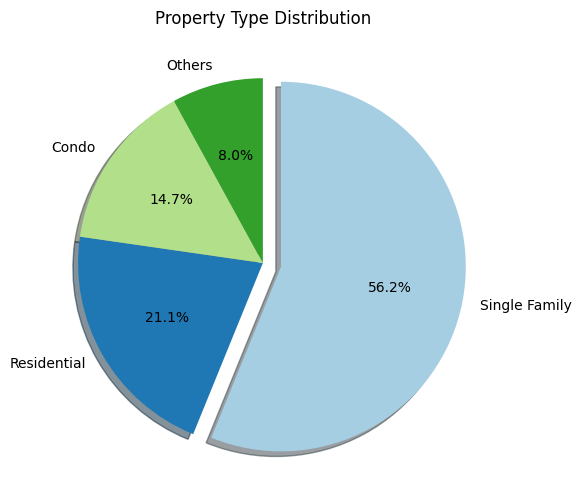

In [ ]:
import matplotlib.pyplot as plt

# Calculate the counts of each property type
property_type_counts = df['Property Type'].value_counts()

# Calculate the threshold count for 3.7%
threshold_count = 0.037 * property_type_counts.sum()

# Combine property types with less than the threshold count into "Others"
property_type_counts_combined = property_type_counts.copy()
property_type_counts_combined[property_type_counts < threshold_count] = 0
property_type_counts_combined['Others'] = property_type_counts[property_type_counts < threshold_count].sum()

# Filter out the zero values
property_type_counts_combined = property_type_counts_combined[property_type_counts_combined > 0]

# Define colors for the pie chart after property_type_counts_combined is defined
colors = plt.cm.Paired(range(len(property_type_counts_combined)))

# Plot the pie chart with updated labels using the latest pie chart libraries
fig, ax = plt.subplots(figsize=(10, 6))
explode = [0.1 if i == 0 else 0 for i in range(len(property_type_counts_combined))]  # Explode the first slice
ax.pie(property_type_counts_combined, labels=property_type_counts_combined.index, autopct='%1.1f%%', startangle=90, counterclock=False, shadow=True, explode=explode, colors=colors)
ax.set_title('Property Type Distribution')
plt.show()

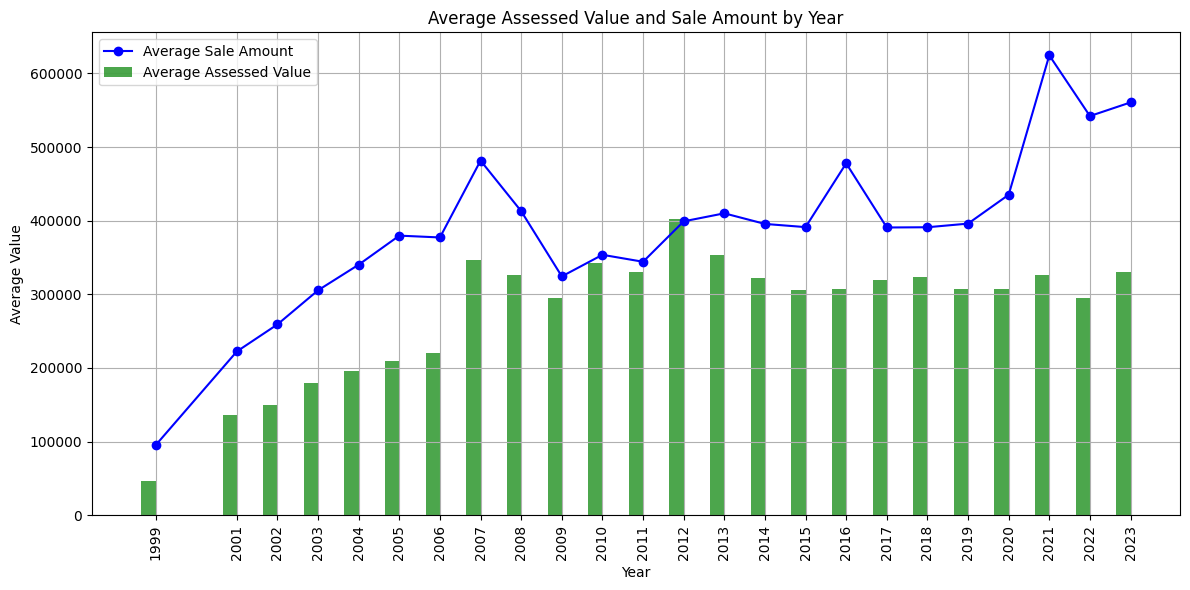

In [ ]:
# Extract the year from 'Date Recorded' and create a new 'Year' column
df['Year'] = pd.to_datetime(df['Date Recorded'], errors='coerce').dt.year

# Calculate average values
average_sale_amount_by_year = df.groupby('Year')['Sale Amount'].mean()
average_values_by_year = df.groupby('Year')[['Assessed Value', 'Sale Amount']].mean()

# Create a figure and axes object
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the line plot and bar plot on the same axes (ax1)
ax1.plot(average_sale_amount_by_year.index, average_sale_amount_by_year.values,
         marker='o', label='Average Sale Amount', color='blue')
width = 0.35  # Width of the bars
ax1.bar(average_values_by_year.index - width/2, average_values_by_year['Assessed Value'],
        width, alpha=0.7, label='Average Assessed Value', color='green')

# Set labels and title
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Value')  # Common y-axis label
ax1.set_title('Average Assessed Value and Sale Amount by Year')

# Customize the plot
ax1.grid(True)
ax1.legend(loc='upper left')  # Adjust legend location if needed
plt.xticks(average_values_by_year.index, rotation=90)
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
df_model_clean = df.dropna(subset=['Sale Amount', 'Assessed Value', 'Year' , 'Town', 'Property Type', 'Residential Type'])
from sklearn.preprocessing import LabelEncoder
residential_type_encoder = LabelEncoder()
property_type_encoder = LabelEncoder()
town_encoder = LabelEncoder()
df_model_clean['PropertyType_encoded'] = property_type_encoder.fit_transform(df_model_clean['Property Type'])
df_model_clean['Town_encoded'] = town_encoder.fit_transform(df_model_clean['Town'])
df_model_clean['ResidentialType_encoded'] = residential_type_encoder.fit_transform(df_model_clean['Residential Type'])

<ipython-input-7-552515f5ba67>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_clean['PropertyType_encoded'] = property_type_encoder.fit_transform(df_model_clean['Property Type'])
<ipython-input-7-552515f5ba67>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_clean['Town_encoded'] = town_encoder.fit_transform(df_model_clean['Town'])
<ipython-input-7-552515f5ba67>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [ ]:
# Initialize the scaler
scaler = StandardScaler()

X = df_model_clean[['Assessed Value', 'Year', 'Town_encoded', 'PropertyType_encoded']]
y = df_model_clean['Sale Amount']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applying a log transformation to 'Assessed Value' and 'Sale Amount' can help address skewness in the data and improve the model's ability to capture relationships.
X_train['Assessed Value'] = np.log1p(X_train['Assessed Value'])
X_test['Assessed Value'] = np.log1p(X_test['Assessed Value'])
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

# Scaling numerical features (like 'Assessed Value' and 'Year') to a similar range can help prevent features with larger values from dominating the model and improve performance, especially for algorithms like Linear Regression.
X_train[['Assessed Value', 'Year']] = scaler.fit_transform(X_train[['Assessed Value', 'Year']])
X_test[['Assessed Value', 'Year']] = scaler.transform(X_test[['Assessed Value', 'Year']])

# Linear Regression
model_lr_raw = LinearRegression()
model_lr_raw.fit(X_train, y_train)
y_pred_lr_raw = model_lr_raw.predict(X_test)
mse_lr_raw = mean_squared_error(y_test, y_pred_lr_raw)
r2_lr_raw = r2_score(y_test, y_pred_lr_raw)
print("Linear Regression - MSE:", mse_lr_raw)
print("Linear Regression - R2:", r2_lr_raw)

# Random Forest
model_rf_raw = RandomForestRegressor(random_state=42)
model_rf_raw.fit(X_train, y_train)
y_pred_rf_raw = model_rf_raw.predict(X_test)
mse_rf_raw = mean_squared_error(y_test, y_pred_rf_raw)
r2_rf_raw = r2_score(y_test, y_pred_rf_raw)
print("Random Forest - MSE:", mse_rf_raw)
print("Random Forest - R2:", r2_rf_raw)


Linear Regression - MSE: 0.5088562117761173
Linear Regression - R2: 0.36171574127652095
Random Forest - MSE: 0.2209815833678217
Random Forest - R2: 0.7228115470200284


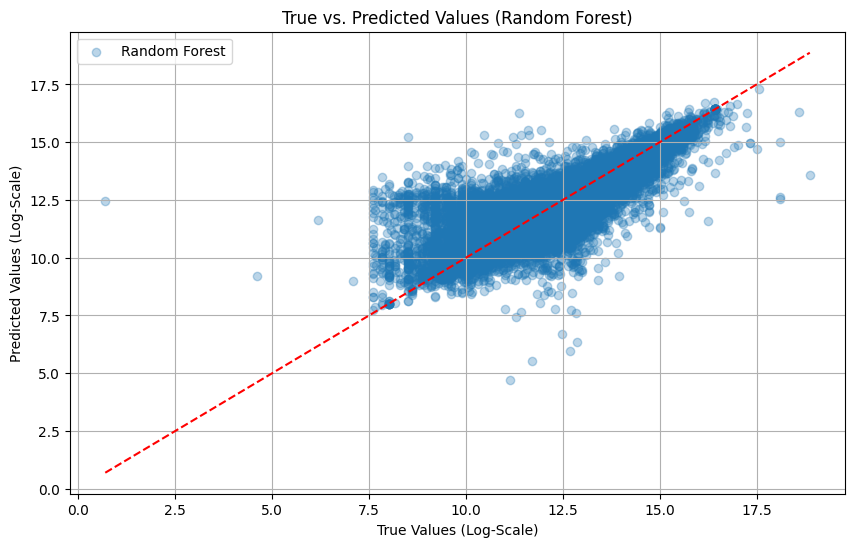

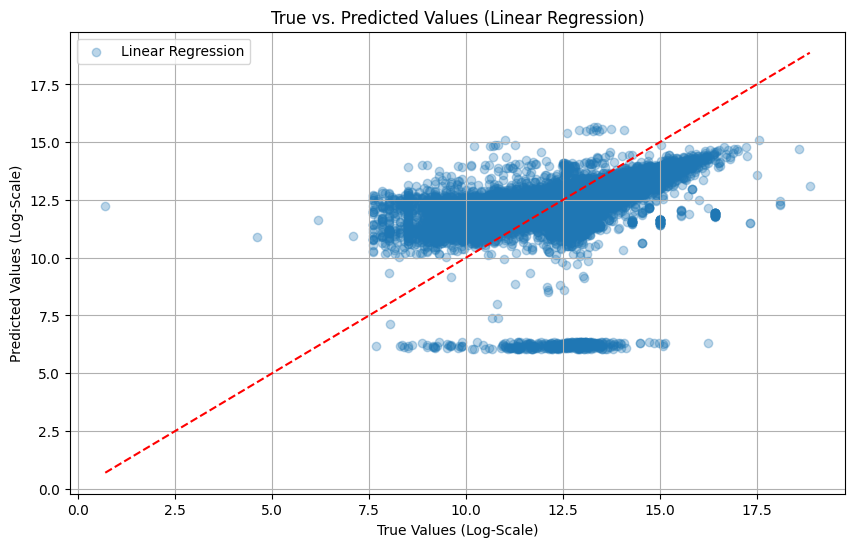

In [ ]:
# Scatter plot of true vs. predicted values for Random Forest (excluding zeros)
mask_rf = (y_test != 0) & (y_pred_rf_raw != 0)
plt.figure(figsize=(10, 6))
plt.scatter(y_test[mask_rf], y_pred_rf_raw[mask_rf], alpha=0.3, label='Random Forest')
plt.plot([min(y_test[mask_rf]), max(y_test[mask_rf])],
         [min(y_test[mask_rf]), max(y_test[mask_rf])],
         color='red', linestyle='--')
plt.xlabel('True Values (Log-Scale)')
plt.ylabel('Predicted Values (Log-Scale)')
plt.title('True vs. Predicted Values (Random Forest)')
plt.grid(True)
plt.legend()
plt.show()

# Scatter plot of true vs. predicted values for Linear Regression (excluding zeros)
mask_lr = (y_test != 0) & (y_pred_lr_raw != 0)
plt.figure(figsize=(10, 6))
plt.scatter(y_test[mask_lr], y_pred_lr_raw[mask_lr], alpha=0.3, label='Linear Regression')
plt.plot([min(y_test[mask_lr]), max(y_test[mask_lr])],
         [min(y_test[mask_lr]), max(y_test[mask_lr])],
         color='red', linestyle='--')
plt.xlabel('True Values (Log-Scale)')
plt.ylabel('Predicted Values (Log-Scale)')
plt.title('True vs. Predicted Values (Linear Regression)')
plt.grid(True)
plt.legend()
plt.show()

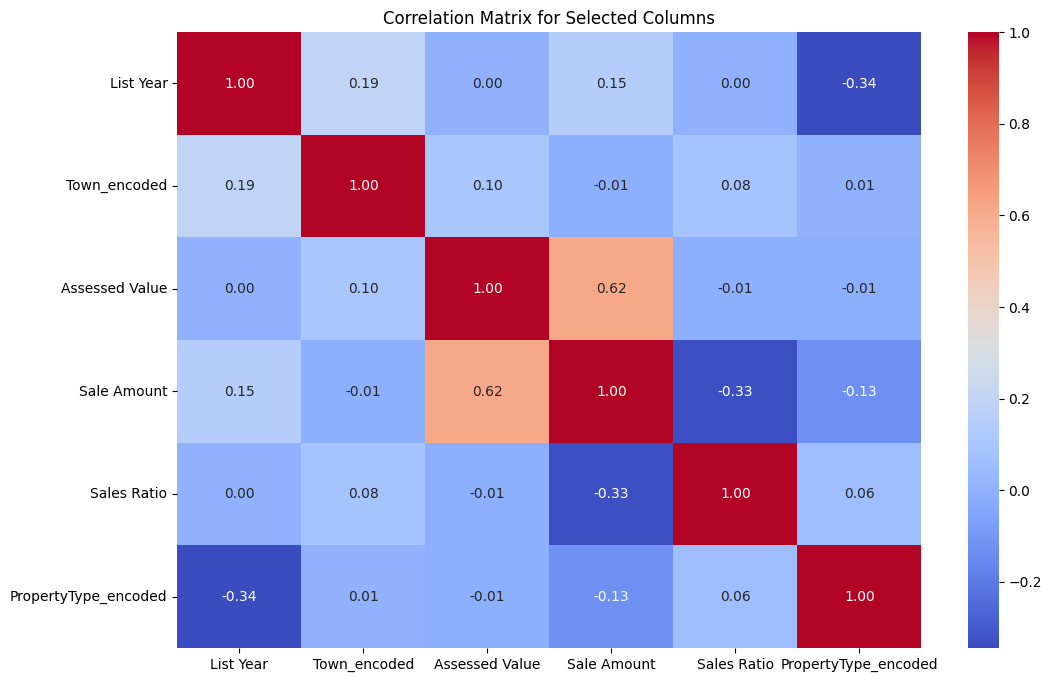

In [ ]:
selected_cols = ['List Year', 'Town_encoded', 'Assessed Value', 'Sale Amount', 'Sales Ratio', 'PropertyType_encoded']
corr_matrix_selected = df_model_clean[selected_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_selected, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix for Selected Columns")
plt.show()
